In [273]:
# make notebook look in correct directory
import os
os.chdir('../src/')

# load required dependencies
import util.setup as setup
import numpy as np
from util import clean_data as cd
import algos.basic as basic
import algos.similarity as sim
import experiments.static as st
import util.viz as viz
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# paths
MDP1 = '../data/Phenotypic_V1_0b_preprocessed1.csv'
PRE1 = '../data/rois_ez/'
POST1 = '_rois_ez.1D'

MDP2 = '../data/Phenotypic_V1_0b_preprocessed1.csv'
PRE2 = '../data/rois_cc200/'
POST2 = '_rois_cc200.1D'

# get meta-data of subjects
tup = setup.get_data2(MDP1, PRE1, POST1, MDP2, PRE2, POST2)
data1, data2, labels1, labels2, num_patients = tup
print len(data2)
print np.sum(labels2 == 1)
print np.sum(labels2 == 2)
# mean center all of the data
data1 = cd.run_function(basic.mean_center, data1)
data2 = cd.run_function(basic.mean_center, data2)

# change from samples x dimensions to dimensions x samples
data1 = cd.run_function(basic.transpose, data1)
data2 = cd.run_function(basic.transpose, data2)

# split subjects into training, testing, tuning (randomly)
n_train = 684
n_tune = 100
n_test = 100
D1, L1 = setup.split_data(data1,
                        labels1,
                        n_train,
                        n_tune,
                        n_test)
D2, L2 = setup.split_data(data2,
                        labels2,
                        n_train,
                        n_tune,
                        n_test)


884
408
476


In [274]:
print len(data1)
print np.sum(labels1 == 1) - np.sum(labels2 == 1)
print np.sum(labels1 == 2)

884
0
476


In [275]:
ND2 = 30
ND1 = 30
NC2 = 8
NC1 = 8
# specify the model to use
model1 = {
    'clust' : sim.spec,
    'correl' : basic.correl,
    'thresh' : np.arange(.01, .1, .032),
    'show_plots' : True,
    'clust_params' : {
        'affinity' : 'precomputed',
        'n_clusters' : NC1,
        'gamma' : .5
    }
}
model2 = {
    'clust' : sim.spec,
    'correl' : basic.correl,
    'thresh' : np.arange(.01, .1, .032),
    'show_plots' : True,
    'clust_params' : {
        'affinity' : 'precomputed',
        'n_clusters' : NC2,
        'gamma' : .5
    }
}
D1TRa = st.block_rep(D1['train']['a'], model1)
D1TRc = st.block_rep(D1['train']['c'], model1)
D2TRa= st.block_rep(D2['train']['a'], model2)
D2TRc = st.block_rep(D2['train']['c'], model2)

D1TRa = cd.run_function(basic.upper_tri, D1TRa)
D1TRc = cd.run_function(basic.upper_tri, D1TRc)
D2TRa= cd.run_function(basic.upper_tri, D2TRa)
D2TRc = cd.run_function(basic.upper_tri, D2TRc)

D1TRa = np.column_stack(D1TRa)
D1TRc = np.column_stack(D1TRc)
D2TRa= np.column_stack(D2TRa)
D2TRc = np.column_stack(D2TRc)

In [276]:
M_a1 = np.mean(D1TRa, axis = 1)
M_c1 = np.mean(D1TRc, axis = 1)
M_1 = M_a1 - M_c1
ind1 = (np.abs(M_1) > .08)
print np.sum(ind1)

81


In [277]:
M_a2 = np.mean(D2TRa, axis = 1)
M_c2 = np.mean(D2TRc, axis = 1)
M_2 = M_a2 - M_c2
ind2 = (np.abs(M_2) > .08)
print np.sum(ind2)

359


In [282]:
V1 = np.hstack((D1TRa, D1TRc))
V2 = np.hstack((D2TRa, D2TRc))
print V1.shape
print V2.shape
V1 = V1[ind1, :]
V2 = V2[ind2, :]
print V1.shape
print V2.shape

(6670, 684)
(19900, 684)
(81, 684)
(359, 684)


In [283]:
phi_1, phi_2 = cd.CCA(V1, V2, 200)
phi_1 = phi_1[:, :ND1]
phi_2 = phi_2[:, :ND2]

In [284]:
print phi_1.shape
print phi_2.shape
proj_d1 = phi_1.T.dot(V1)
proj_d2 = phi_2.T.dot(V2)
print proj_d1.shape
print proj_d2.shape

(81, 30)
(359, 30)
(30, 684)
(30, 684)


In [285]:
V1 = np.hstack((D1TRa, D1TRc)) * M_1.reshape(-1, 1)
V2 = np.hstack((D2TRa, D2TRc)) * M_2.reshape(-1, 1)
F = np.vstack((proj_d1, proj_d2, V1, V2))
print F.shape
labels = D1TRa.shape[1] * [1]
labels = labels + D1TRc.shape[1] * [2]
print len(labels)

(26630, 684)
684


In [286]:
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [287]:
per = MLPClassifier()
clf = SVC(kernel='rbf')
per.fit(F.T, labels)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [292]:
D1Tu = st.block_rep(D1['tune'], model1)
D2Tu = st.block_rep(D2['tune'], model2)

D1Tu = cd.run_function(basic.upper_tri, D1Tu)
D2Tu = cd.run_function(basic.upper_tri, D2Tu)

D1Tu = np.column_stack(D1Tu)
D2Tu = np.column_stack(D2Tu)

V1Tu = D1Tu[ind1, :]
V2Tu = D2Tu[ind2, :]

proj_test_D1 = phi_1.T.dot(V1Tu)
proj_test_D2 = phi_2.T.dot(V2Tu)

V1 = D1Tu * M_1.reshape(-1, 1)
V2 = D2Tu * M_2.reshape(-1, 1)

F_test = np.vstack((proj_test_D1, proj_test_D2, V1, V2))
print per.score(F_test.T, L1['tune'])

0.69


In [291]:
D1Tu = st.block_rep(D1['test'], model1)
D2Tu = st.block_rep(D2['test'], model2)

D1Tu = cd.run_function(basic.upper_tri, D1Tu)
D2Tu = cd.run_function(basic.upper_tri, D2Tu)

D1Tu = np.column_stack(D1Tu)
D2Tu = np.column_stack(D2Tu)

V1Tu = D1Tu[ind1, :]
V2Tu = D2Tu[ind2, :]

proj_test_D1 = phi_1.T.dot(V1Tu)
proj_test_D2 = phi_2.T.dot(V2Tu)

V1 = D1Tu * M_1.reshape(-1, 1)
V2 = D2Tu * M_2.reshape(-1, 1)

F_test = np.vstack((proj_test_D1, proj_test_D2, V1, V2))
print per.score(F_test.T, L1['test'])

0.59


[1 2 2 2 2 1 2 1 1 2 1 1 2 2 1 2 2 2 2 1 2 1 2 2 1 2 2 1 1 1 2 2 2 2 2 1 2
 2 2 1 2 2 2 2 2 2 1 1 2 1 1 2 2 1 2 2 2 1 1 2 1 2 2 1 1 2 2 2 2 1 1 1 1 1
 2 2 2 1 2 2 2 2 1 2 2 1 2 1 1 2 2 1 1 2 2 1 1 1 2 2]
[  3.86756465e-01   1.13462807e-01   6.86146573e-01   1.67369539e-02
   3.68773637e-01   9.98485116e-01   1.43871959e-01   2.88704158e-01
   9.57177348e-03   7.49549863e-01   6.49330825e-03   4.29726202e-01
   1.47780233e-01   2.74499779e-01   1.94866948e-01   9.48082863e-01
   7.31442478e-02   9.57688264e-01   1.22418701e-02   9.83022387e-01
   1.54889857e-01   6.22385805e-03   8.84972831e-01   5.62636436e-01
   4.96176621e-02   2.00365724e-01   6.32441908e-01   9.37247755e-01
   6.72592938e-03   1.02466870e-01   2.79551339e-02   1.37985361e-01
   4.69411562e-01   4.28024391e-01   7.88279715e-01   1.80641683e-01
   5.21846483e-02   4.76293491e-02   8.55540367e-01   6.51516487e-03
   9.98072654e-01   5.43872129e-02   8.05250876e-01   7.54208582e-01
   1.39993932e-01   3.83508955e-02   

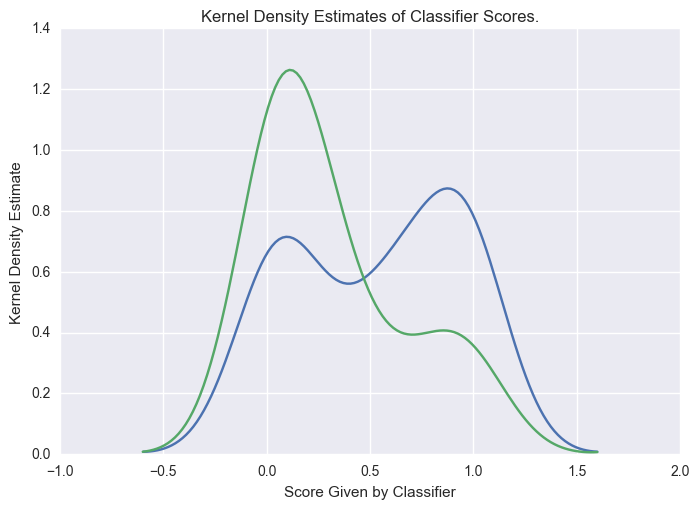

In [294]:
ev = per.predict_proba(F_test.T)[:, 0]
ev_a = ev[L1['tune'] == 1]
ev_c = ev[L1['tune'] == 2]
print L1['test']
print ev
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.kdeplot(ev_a, bw=.2)
sns.kdeplot(ev_c, bw=.2)
plt.title("Kernel Density Estimates of Classifier Scores.")
plt.xlabel("Score Given by Classifier")
plt.ylabel("Kernel Density Estimate")
plt.show()